### settings

In [1]:
import datetime
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/MyDrive/BigContest

/content/drive/MyDrive/BigContest


In [4]:
!pip install optuna

# 시각 점수 음향 점수 산출

## 시각 점수

In [5]:
#L2 거리 구하기
def L2_norm(x):
    x_norm = x[0]**2 + x[1]**2 + x[2]**2
    x_norm = np.sqrt(x_norm)
    return x_norm

#무대 중심과 그룹핑된 좌석 중심 좌표를 받은 후 라디안 각도 구하기
def dist_angle(center, x):
    standard_vector = (0, 1, 0)
    vector = (x[0]-center[0], x[1]-center[1], x[2]-center[2]) #무대 중심에서 좌석까지 벡터
    cos = np.inner(vector, standard_vector) / (L2_norm(vector) * L2_norm(standard_vector))
    theta = np.arccos(cos)
    return (L2_norm(vector), theta)

In [6]:
#미리미터단위
floor_h = 5000 #층고
height_stage = 1000 #무대 중심 높이
height_2f = 260*17 + floor_h #2층 시작 높이
height_3f = height_2f + floor_h + 260*5 #3층 시작 높이


#피아노독주 외의 공연
stage_1f = (40744.01, 16962.62, height_stage)
stage_2f = (38953.37, 19182.57, height_stage)
stage_3f = (40157.66, 18344.74, height_stage)

#피아노 독주
stage_1f_piano = (45465.44, 16957.2, height_stage)
stage_2f_piano = (43668.24, 19182.57, height_stage)
stage_3f_piano = (44899.48, 18344.74, height_stage)

In [7]:
#fastview를 통해 구한 그룹핑된 좌석들의 대표 좌표값 (1층)

pointer_1f = [(53730.8, 24121.11, 390), (47691.49, 24984.98, 390), (40744.01, 25716.22, 390), (33816.63, 24984.98, 390),(27757.21, 24121.11, 390),
             (54789.56, 28136.74, 1560), (48154.53, 29364.95, 1560), (40744.01, 29847.45, 1560), (33333.48, 29364.95, 1560), (26698.45, 28136.74, 1560),
             (55901.92, 32391.86, 2730), (48614.79, 33766.42, 2730), (40744.01, 34266.14, 2730), (32873.22, 33766.42, 2730), (25586.09, 32391.86, 2730),
             (56721.63, 36073.02, 3640), (49090.46, 37505.86, 3640), (40744.01, 38315.74, 3640), (32397.55, 37505.86, 3640), (24766.39, 36073.02, 3640),
             (56587.8, 38711.67, 4420), (49379, 40050.84, 4420), (40744.01, 40599.62, 4420), (32109.01, 40050.84, 4420), (24900.22, 38711.67, 4420),
             (56493.34, 41772.69, 5200), (49743.57, 42848.67, 5200), (40744.01, 43210.74, 5200), (31744.35, 42848.67, 5200), (24994.67, 41772.7, 5200)]

In [8]:
#fastview를 통해 구한 그룹핑된 좌석들의 대표 좌표값 (2층)

pointer_2f = [(51709.04, 38612.19, height_2f+130), (45484.77, 43099.58, height_2f+130), (38953.37, 43744, height_2f+130), (32439.18, 43099.58, height_2f+130), (26214.9, 38612.19, height_2f+130),
             (53442.28, 40378.89, height_2f+780), (46031.25, 45042.05, height_2f+780), (38953.37, 45980, height_2f+780), (31892.69, 45042.05, height_2f+780), (24481.6, 40378.89, height_2f+780),
             (54364.38, 43910.42, height_2f+1560), (47170.98, 47554.78, height_2f+1560), (38953.37, 48500, height_2f+1560), (30752.97, 47554.78, height_2f+1560), (23559.57, 43910.42, height_2f+1560),
             (56962.82, 34352.37, height_2f+130), (20750.86, 34437.27, height_2f+130),
             (55612.363, 32637.98, height_2f-390), (22723.38, 33037.77, height_2f-390),
             (55742.87, 29885.17, height_2f-650), (22181.08, 29885.17, height_2f-650),
             (54269.82, 28683.08, height_2f-1170), (23654.12, 28683.08, height_2f-1170),
             (54101.64, 25320.64, height_2f-1820), (23822.3, 25320.64, height_2f-1820),
             (49945.02, 38365.14-16225.12, height_2f-1950), (48764.09, 38365.14-11614.38, height_2f-1950),(44426.97, 38365.14-7917.04, height_2f-1950), (38953.37, 38365.14-7917.04, height_2f-1950), (33426.97, 38365.14-7772.57, height_2f-1950), (29142.65, 38365.14-11614.38, height_2f-1950), (27961.72, 38365.14-16225.12, height_2f-1950)]

In [9]:
#fastview를 통해 구한 그룹핑된 좌석들의 대표 좌표값 (3층)

pointer_3f = [(56473.38, 36461.47, height_3f-520), (23889.12, 36515.12, height_3f-520),
             (56199.47, 39912.39, height_3f+130), (52580.2, 44458.33, height_3f+130), (47299.03, 46705.75, height_3f+130), (40184.61, 47013.66, height_3f+130), (33016.29, 46705.75, height_3f+130), (27735.12, 44458.33, height_3f+130), (24115.85, 39912.39, height_3f+130),
             (56894.45, 42374.88, height_3f+650), (53830.44, 45859.33, height_3f+650), (47875.95, 48529.5, height_3f+650), (40184.61, 49284.95, height_3f+650), (32439.37, 48529.5, height_3f+650), (26484.88, 45859.33, height_3f+650), (23420.87, 42374.88, height_3f+650),
             (47168.66, 52163.54, height_3f+1300), (33146.66, 52163.54, height_3f+1300),
             (56946.49, 32116.56, height_3f-1170), (23542.87, 31840.94, height_3f-1170),
             (56063.75, 28086.96, height_3f-2080), (24251.56, 28086.96, height_3f-2080),
             (55165.76, 24096, height_3f-2730), (25149.56, 24096, height_3f-2730)]

In [10]:
#좌표 기반으로 거리 및 각도 산출

#피아노 독주 외 공연 : common
common_value_1f = [dist_angle(stage_1f, p) for p in pointer_1f]
common_value_2f = [dist_angle(stage_2f, p) for p in pointer_2f]
common_value_3f = [dist_angle(stage_3f, p) for p in pointer_3f]

#피아노 독주 공연 : piano
piano_value_1f = [dist_angle(stage_1f_piano, p) for p in pointer_1f]
piano_value_2f = [dist_angle(stage_2f_piano, p) for p in pointer_2f]
piano_value_3f = [dist_angle(stage_3f_piano, p) for p in pointer_3f]

In [11]:
block = ['A','B','C','D','E']

In [12]:
#임의로 명명한 그룹명 인덱스 만들기

common_dist = [dist[0] for dist in common_value_1f] + [dist[0] for dist in common_value_2f] + [dist[0] for dist in common_value_3f]
common_angle = [angle[1] for angle in common_value_1f] + [angle[1] for angle in common_value_2f] + [angle[1] for angle in common_value_3f]

piano_dist = [dist[0] for dist in piano_value_1f] + [dist[0] for dist in piano_value_2f] + [dist[0] for dist in piano_value_3f]
piano_angle = [angle[1] for angle in piano_value_1f] + [angle[1] for angle in piano_value_2f] + [angle[1] for angle in piano_value_3f]

index1 = [b+str(i) for i in range(1,7) for b in block]
index2 = [b+str(i) for i in range(7,10) for b in block] + ['X'+str(i) for i in [5,10,4,9,3,8,2,7,1,6]] + ['H'+str(i) for i in range(1,8)]
index3 = ['A10','G10','A11','B10','C10','D10','E10','F10','G11','A12','B11','C11','D11','E11','F11','G12','M1','M2'] + ['X'+str(i) for i in [13,16,12,15,11,14]]
index = index1 + index2 + index3

In [13]:
common_total_df = pd.DataFrame({'dist':common_dist,'angle':common_angle},index=index)
piano_total_df = pd.DataFrame({'dist':piano_dist,'angle':piano_angle},index=index)

In [14]:
common_total_df.describe()

,dist,angle
count,86.000000,86.000000
mean,24228.406126,0.677181
std,7080.252172,0.307887
min,8774.828372,0.043435
25%,18830.598685,0.447174
50%,25049.178211,0.641385
75%,29685.376488,0.913041
max,38072.375214,1.342948


In [15]:
piano_total_df.describe()

,dist,angle
count,86.000000,86.000000
mean,24581.627814,0.686635
std,7434.242711,0.303740
min,8353.002474,0.210596
25%,18812.099100,0.488544
50%,25347.732733,0.632631
75%,30106.847263,0.901720
max,39223.467611,1.398423


In [16]:
#거리와 각도 0~1 스케일링 진행

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_common_df = pd.DataFrame(scaler.fit_transform(common_total_df),columns=common_total_df.columns,index=common_total_df.index)
scaled_piano_df = pd.DataFrame(scaler.fit_transform(piano_total_df),columns=piano_total_df.columns,index=piano_total_df.index)

Text(0.5, 1.0, 'piano')

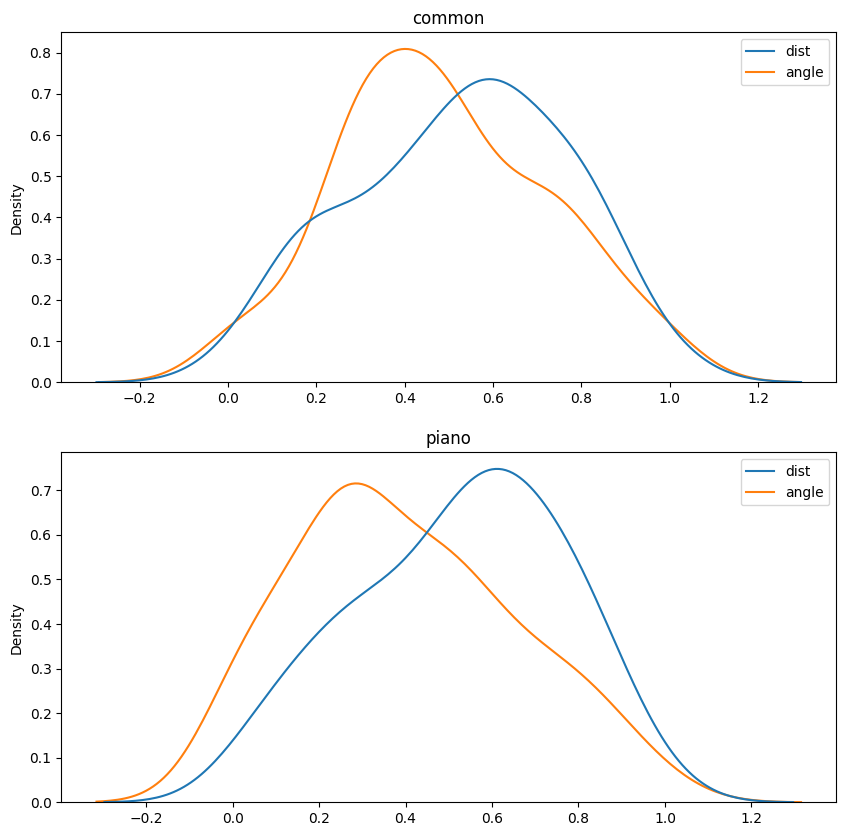

In [17]:
#거리 및 각도 분포 확인

import seaborn as sns
import matplotlib.pyplot as plt

fig,axes = plt.subplots(2,1,figsize=(10,10))
sns.kdeplot(scaled_common_df,ax=axes[0])
axes[0].set_title('common')
sns.kdeplot(scaled_piano_df,ax=axes[1])
axes[1].set_title('piano')

In [18]:
#가중치를 통한 시각 점수 산출
def weight_calculate(df,weights):
    dist_w, angle_w = weights[0],weights[1]
    score = df['dist']*dist_w + df['angle']*angle_w
    return -pd.DataFrame(score, columns=['score'])

In [19]:
common_ret_df = weight_calculate(scaled_common_df,(0.5,0.5)) #1대1
common_ret_df = common_ret_df.sort_values(by='score', ascending=False)

piano_ret_df = weight_calculate(scaled_piano_df,(0.7,0.3)) #7대3
piano_ret_df = piano_ret_df.sort_values(by='score', ascending=False)

## 음향 점수

In [20]:
#전체 그룹 86개를 층별로 나눔
#층별로 하는 이유? fastview 좌표값이 층별로 다름

sound1 = np.zeros((30, 5))
sound2 = np.zeros((32, 5))
sound3 = np.zeros((24, 5))

In [21]:
#논문 기반 음향 점수 입력 (ITDG, IACC, EDT, C80, BR)

#-------------------1층---------------------------------
#1 A2, A3, E2, E3
sound1[[5, 9, 10, 14]] = np.array([14.6, 0.45, 2.03, -0.65, 0.99])

#2 A4, A5, B4, B5
sound1[[15, 19, 20, 24]] = np.array([17.7, 0.43, 2.03, -2.15, 1.03])

#16 A6, E6
sound1[[25, 29]] = np.array([7, 0.27, 1.88, -1.1, 1.16])

#3 B2, B3, D2, D3
sound1[[6, 8, 11, 13]] = np.array([27.1, 0.47, 2.07, -2.75, 1.08])

#4 B4, B5, D4, D5
sound1[[16, 18, 21, 23]] = np.array([14.6, 0.42, 1.94, -2.24, 1.09])

# A1, E1 = A2
sound1[[0, 4]] = sound1[5]

# B1, D1 = B2
sound1[[1, 3]] = np.array([27.1, 0.47, 2.07, -2.75, 1.08])

# B6, D6 = A6 + B5의 평균
sound1[[26, 28]] = (sound1[21] + sound1[25]) / 2

#----------------2층---------------------------------------

#5
sound2[[0, 4]] = np.array([29.1, 0.57, 1.98, -0.68, 1.07])

#6
sound2[[10, 14]] = np.array([14.6, 0.41, 2.18, -2.29, 1.10])

#7
sound2[[1, 3]] = np.array([29.2, 0.61, 1.83, -1.07, 1.14])

#8
sound2[[11, 13]] = np.array([29.2, 0.62, 1.71, -2.96, 1.17])

#9
sound2[[15, 16, 17, 18]] = np.array([12.5, 0.67, 1.85, -0.41, 1.19])

#10
sound2[[23, 24]] = np.array([22.9, 0.4, 1.86, -0.41, 1.15])

#14
sound2[[25, 26, 30, 31]] = np.array([14.5, 0.65, 2.03, -0.84, 1.14])

#15
sound2[[27, 28, 29]] = np.array([18.8, 0.57, 2.12, -1.21, 1.10])

#보간(초기지연시간)
sound2[[19, 20, 21, 22]] = (sound2[18] + sound2[24]) / 2

sound2[[5, 9]] = (sound2[4] + sound2[14]) / 2
sound2[[6, 8]] = (sound2[13] + sound2[3]) / 2

#-----------------------3층--------------------------------
#11
sound3[[2, 9, 8, 15]] = np.array([14.7, 0.46, 1.85, -1.13, 1.15])

#12
sound3[[4, 11, 6, 13]] = np.array([14.5, 0.44, 1.95, 1.01, 1.09])

#13
sound3[[18, 19, 20, 21, 22, 23]] = np.array([19.8, 0.63, 1.82, 2.28, 1.11])

#예측
sound3[[3, 7, 10, 14]] = sound3[8]

#보간
sound3[[0,1]] = (sound3[18] + sound3[2]) / 2

In [22]:
def range_filtering(value, range):
    if value <= range[1] and value >= range[0]:
        return 0
    elif value > range[1]:
        return np.abs(value-range[1])
    elif value < range[0]:
        return np.abs(value-range[0])

#설정 범위 안에 들지 않을 경우 범위 threshhold와의 gap 구하기
def filtering(array):
    array = np.array([range_filtering(array[0], [15, 30]), range_filtering(array[1], [0.34, 0.34]), range_filtering(array[2], [1.8, 2]), range_filtering(array[3], [-2, -2]), range_filtering(array[4], [1.03, 1.11])])
    return array

In [23]:
#층별로 처리

sound_1 = []
for i in sound1:
    sound_1.append(filtering(i))

sound_2 = []
for i in sound2:
    sound_2.append(filtering(i))

sound_3 = []
for i in sound3:
    sound_3.append(filtering(i))

In [24]:
sound_df1 = pd.DataFrame(np.array(sound_1), columns = ['ITDG', 'IACC', 'RT', 'C80', 'BR'])
sound_df2 = pd.DataFrame(np.array(sound_2), columns = ['ITDG', 'IACC', 'RT', 'C80', 'BR'])
sound_df3 = pd.DataFrame(np.array(sound_3), columns = ['ITDG', 'IACC', 'RT', 'C80', 'BR'])

df = pd.concat([sound_df1, sound_df2, sound_df3])
df["index"] = index1+index2+index3
df = df.set_index('index')
df.head()

,ITDG,IACC,RT,C80,BR
index,,,,,
A1,0.4,0.11,0.03,1.35,0.04
B1,0.0,0.13,0.07,0.75,0.00
C1,15.0,0.34,1.80,2.00,1.03
D1,0.0,0.13,0.07,0.75,0.00
E1,0.4,0.11,0.03,1.35,0.04


In [25]:
#논문에서 음향 점수 파악할 수 자리 잠시 제외

df_ = df.loc[df["ITDG"] != 15]
len(df_), len(df)

(73, 86)

In [26]:
df_copy = df_.copy()

#음향점수 columns 5가지를 각각 독립적으로 1~5점으로 변환 (gap이 클수록 1점 작을수록 5점)
for col in df_copy.columns:
    for i in range(5,0,-1):
        val = df_[col].quantile(0.2*i)
        df_copy.loc[df_[col]<=val,col] = 6-i

In [27]:
df_copy["sum"] = df_copy.sum(axis = 1)

#잠시 제외한 좌석들 추가. 이들의 sum 점수는 뉴스, 블로그 후기, 경험담 서칭을 통해 다른 좌석과 비교하여 적당한 점수로 대입
df_cdm = df.loc[df["ITDG"] == 15]
df_cdm['sum'] = [16,18,20,24,24,24,18,14,12,17,17,17,17]

df_copy = pd.concat([df_copy,df_cdm],axis=0)

acoustic_score = df_copy[['sum']]
acoustic_score.head()

,sum
index,
A1,13.0
B1,18.0
D1,18.0
E1,13.0
A2,13.0


In [28]:
#음향 점수 0~1 스케일링

scaler = MinMaxScaler()
scaled_score = pd.DataFrame(scaler.fit_transform(acoustic_score),columns=acoustic_score.columns,index=acoustic_score.index)

## 시각 + 음향 점수 산출

In [29]:
final_common = pd.merge(common_ret_df, scaled_score,left_index=True, right_index=True,how='left')
final_common.columns = ['visual','acoustic']
final_common['visual'] = final_common['visual'].values+1

final_piano = pd.merge(piano_ret_df, scaled_score,left_index=True, right_index=True,how='left')
final_piano.columns = ['visual','acoustic']
final_piano['visual'] = final_piano['visual'].values+1

In [30]:
# final_common.to_csv('./common_vis_acoustic.csv',index=False)
# final_piano.to_csv('./piano_vis_acoustic.csv',index=False)

In [31]:
# 각각 가중치 적절히해서 합치기

# <데이터 전처리 수행>

## 전처리

In [32]:
import datetime

### 1. 기존 raw dataset 불러오기
- play_date : datetime 형태로 변환
- raw 데이터가 실제 공연과 대비해 7일 딜레이 되어 있음을 확인. play_date 컬럼에 대하여 원래 날짜로 복구 진행.
- play_date 기반으로 'year' / 'month' 컬럼 생성.
- 코로나 영향을 받지 않은 2018, 209, 2022 하반기, 2023 데이터만 활용
- 콘서트홀에서 진행된 공연에 대해서만 수행

In [33]:
df_raw = pd.read_csv("./2023빅콘테스트_어드밴스드리그_예술의전당.csv")

In [34]:
df_raw['play_date'] = df_raw['play_date'].astype(str)
df_raw['play_date'] = pd.to_datetime(df_raw['play_date'])
df_raw['play_date'].dt.strftime('%Y-%m-%d')
df_raw['play_date'] = pd.to_datetime(df_raw['play_date'])

In [35]:
# df_raw['play_date'] = df_raw['play_date'].apply(lambda x: pd.to_datetime(str(x), format='%Y-%m-%d'))#; df_raw['play_date']

In [36]:
df_raw['play_date'] = df_raw['play_date'] + datetime.timedelta(days=-7)

In [37]:
df_raw['year'] = df_raw['play_date'].dt.year

In [38]:
df_raw['month'] = df_raw['play_date'].dt.month

In [39]:
df_raw = df_raw[df_raw['year'].isin([2018, 2019, 2022, 2023])]

In [40]:
df_raw = df_raw[~((df_raw['year'] == 2022) & (df_raw['month'].isin([1, 2, 3, 4, 5, 6])))]

In [41]:
df_raw = df_raw[df_raw['place'] =='콘서트홀']

In [42]:
df_raw = df_raw[['age', 'gender', 'play_date', 'play_st_time', 'tran_date', 'tran_time','seat','price', 'running_time', 'year', 'month', 'member_yn']]

In [43]:
df = df_raw.groupby(['play_date', 'play_st_time'])[['age', 'gender', 'seat', 'price', 'running_time', 'year']].mean()

In [44]:
df = df.reset_index()
df.head()

,play_date,play_st_time,age,price,running_time,year
0,2018-11-18,1700,52.131148,2129.812981,120.0,2018.0
1,2018-12-01,1700,45.573770,1223.710922,140.0,2018.0
2,2018-12-11,2000,48.700210,6736.814891,120.0,2018.0
3,2018-12-13,2000,NaN,0.000000,100.0,2018.0
4,2018-12-16,1500,NaN,0.000000,120.0,2018.0


### 예술의 전당 공연명 데이터 불러오기 (2018, 2019, 2022 하반기, 2023)
- 코로나 영향을 받지 않은 2018, 2019, 2022 하반기, 2023 데이터만 활용
콘서트홀에서 진행된 공연에 대해서만 수행

In [45]:
#외부에서 따로 직접 가져온 데이터

df_2018 = pd.read_csv("./2018.csv")
df_2019 = pd.read_csv("./2019.csv")
df_2022 = pd.read_csv("./2022.csv")
df_2023 = pd.read_csv("./2023.csv")

In [46]:
df_2018 = df_2018[df_2018['장소']=='콘서트홀']
df_2019 = df_2019[df_2019['장소']=='콘서트홀']
df_2022 = df_2022[df_2022['장소']=='콘서트홀']
df_2023 = df_2023[df_2023['장소']=='콘서트홀']

In [47]:
df_new = pd.concat([df_2018, df_2019, df_2022, df_2023], axis=0)

In [48]:
df_new['play_date'] = pd.to_datetime(df_new['기간'])

In [49]:
df2 = pd.merge(df, df_new, how = 'inner', on ='play_date')

In [50]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 468 entries, 0 to 467
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   play_date     468 non-null    datetime64[ns]
 1   play_st_time  468 non-null    int64         
 2   age           417 non-null    float64       
 3   price         468 non-null    float64       
 4   running_time  468 non-null    float64       
 5   year          468 non-null    float64       
 6   번호            468 non-null    int64         
 7   공연/전시구분       468 non-null    object        
 8   장르            431 non-null    object        
 9   공연/전시명        468 non-null    object        
 10  기간            468 non-null    object        
 11  장소            468 non-null    object        
dtypes: datetime64[ns](1), float64(4), int64(2), object(5)
memory usage: 47.5+ KB


In [51]:
#df2.to_csv("df_new.csv",index=False)

## 객단가 계산 코드

In [52]:
df = pd.read_csv("./2023빅콘테스트_어드밴스드리그_예술의전당.csv")

In [53]:
df = df.loc[df["place"]=="콘서트홀"]

In [54]:
df['date_time'] = pd.to_datetime(df['play_date'].astype(str))
df['date_time'].dt.strftime('%Y-%m-%d')
df['date_time'] = pd.to_datetime(df['date_time'])

In [55]:
df = df.loc[(df["date_time"] < "2020-01-07")|(df["date_time"] > "2022-01-07")]

In [56]:
df.drop(["age", "gender", "membership_type_1", "membership_type_2", "membership_type_3", "membership_type_4", "membership_type_5", "membership_type_6", "intermission", "running_time", "place", "date_time"], inplace = True, axis= 1)

In [57]:
import numpy as np
for i in set(df.genre.values):
  print(i, len(np.unique(df.loc[df.genre==i][["play_date", "play_st_time"]].values, axis = 0)))

교향곡 237
크로스오버 1
독주 30
합창 55
실내악 19
재즈 1
복합장르 3
오페라 10
nan 0
클래식 116
기타 3
콘서트 14
성악 18


In [58]:
df_list = []
unique_seats = df['seat'].unique()

seat_dict = {unique_seats[seat] : seat for seat in range(len(unique_seats))}
return_dict = {seat : unique_seats[seat] for seat in range(len(unique_seats))}
df["seat"] = df["seat"].map(seat_dict)

for [i, j] in np.unique(df[["play_date", "play_st_time"]].values, axis= 0):
  df_list.append([[i, j], df.loc[(df["play_date"]==i)&(df["play_st_time"]==j)&(df["price"]!=0)]])

In [59]:
print(len(df_list))

517


In [60]:
import tqdm

ind_price = pd.DataFrame(columns = ["play_date", "play_st_time", "객단가", "revenue", "sales"])


for k in tqdm.tqdm(range(len(df_list))):
    df = df_list[k][1]
    df = df.drop_duplicates(subset='seat', keep='first')
    ind_price.loc[len(ind_price)] = [df_list[k][0][0],df_list[k][0][1], np.mean(df["price"].values), np.sum(df["price"].values), len(df["price"].values)]

100%|██████████| 517/517 [00:01<00:00, 377.81it/s]


In [61]:
ind_price["play_date"] = pd.to_datetime(pd.to_datetime(ind_price["play_date"].astype(int).astype(str)).dt.strftime('%Y-%m-%d'))-pd.DateOffset(days=7)

In [62]:
df2["play_date"] = df2["play_date"].astype(str)

In [63]:
ind_price["play_date"] = ind_price["play_date"].astype(str)

In [64]:
ind_price

,play_date,play_st_time,객단가,revenue,sales
0,2018-11-18,1700.0,51415.384615,3342000.0,65.0
1,2018-12-01,1700.0,45803.278689,2794000.0,61.0
2,2018-12-11,2000.0,22437.229437,10366000.0,462.0
3,2018-12-13,2000.0,NaN,0.0,0.0
4,2018-12-16,1500.0,NaN,0.0,0.0
...,...,...,...,...,...
512,2023-06-25,1700.0,31716.568545,37711000.0,1189.0
513,2023-06-27,1930.0,99733.047210,116189000.0,1165.0
514,2023-06-28,1930.0,68090.116279,46846000.0,688.0
515,2023-06-29,1100.0,22383.507853,34202000.0,1528.0


In [65]:
ind_price["play_st_time"] = ind_price["play_st_time"].astype(int)

In [66]:
df = pd.merge(df2, ind_price, on=['play_date', 'play_st_time'], how='left')
#df.to_excel("0927_객단가.xlsx", index=False)

In [67]:
#df = pd.read_excel("/content/drive/MyDrive/BIGCON/0927/0927_객단가.xlsx")

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 468 entries, 0 to 467
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   play_date     468 non-null    object 
 1   play_st_time  468 non-null    int64  
 2   age           417 non-null    float64
 3   price         468 non-null    float64
 4   running_time  468 non-null    float64
 5   year          468 non-null    float64
 6   번호            468 non-null    int64  
 7   공연/전시구분       468 non-null    object 
 8   장르            431 non-null    object 
 9   공연/전시명        468 non-null    object 
 10  기간            468 non-null    object 
 11  장소            468 non-null    object 
 12  객단가           418 non-null    float64
 13  revenue       468 non-null    float64
 14  sales         468 non-null    float64
dtypes: float64(7), int64(2), object(6)
memory usage: 58.5+ KB


In [69]:
df.shape

(468, 15)

## 해당 데이터 프레임에 대하여 후원 / 내한 공연 / 뉴스 개수 / 공연 텍스트 정보에 대하여 직접 크롤링하여 새로운 데이터 프레임을 생성한다.
- 크롤링을 통해 생성한 0925_all_text xlsx 파일.

In [70]:
mm = pd.read_csv("./2023빅콘테스트_어드밴스드리그_예술의전당.csv")
mm = mm.loc[mm["place"]=="콘서트홀"]
mm["date_time"] = pd.to_datetime(mm["play_date"].astype(str)).dt.strftime('%Y-%m-%d')

mm = mm.loc[(mm["date_time"] < "2020-01-07")|(mm["date_time"] > "2022-01-07")]

mm.loc[mm["member_yn"] == "Y", "member_yn"] = 1
mm.loc[mm["member_yn"] == "N", "member_yn"] = 0

mm.drop(["age", "gender", "membership_type_1", "membership_type_2", "membership_type_3", "membership_type_4", "membership_type_5", "membership_type_6", "intermission", "running_time", "place", "date_time"], inplace = True, axis= 1)

df_list = []
unique_seats = mm['seat'].unique()

seat_dict = {unique_seats[seat] : seat for seat in range(len(unique_seats))}
return_dict = {seat : unique_seats[seat] for seat in range(len(unique_seats))}
mm["seat"] = mm["seat"].map(seat_dict)

for [i, j] in np.unique(mm[["play_date", "play_st_time"]].values, axis= 0):
  df_list.append([[i, j], mm.loc[(mm["play_date"]==i)&(mm["play_st_time"]==j)&(mm["price"]!=0)]])

import tqdm

ind_membership = pd.DataFrame(columns = ["play_date", "play_st_time", "membership"])


for k in tqdm.tqdm(range(len(df_list))):
    mm = df_list[k][1]
    mm = mm.drop_duplicates(subset='seat', keep='first')
    ind_membership.loc[len(ind_membership)] = [df_list[k][0][0],df_list[k][0][1], np.mean(mm["member_yn"].values)]

ind_membership["play_date"] = pd.to_datetime(pd.to_datetime(ind_membership["play_date"].astype(int).astype(str)).dt.strftime('%Y-%m-%d'))-pd.DateOffset(days=7)

ind_membership["play_date"] = ind_membership["play_date"].astype(str)
ind_membership["play_st_time"] = ind_membership["play_st_time"].astype(int)

100%|██████████| 517/517 [00:01<00:00, 326.97it/s]


In [71]:
ind_membership.shape

(517, 3)

In [72]:
new_df = pd.merge(df, ind_membership, on = ["play_date", "play_st_time"], how = "left")

In [73]:
new_df.shape

(468, 16)

In [74]:
## new_df에 외부에서 손수 크롤링하고 수집한 데이터(코드 없음)를 붙인 0925_all_text.xlsx 파일 read
## new_df에 외부데이터 붙이는 과정은 생략되어있습니다

In [75]:
new_df = pd.read_excel("./0925_all_text.xlsx")

In [76]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 468 entries, 0 to 467
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   play_date     468 non-null    datetime64[ns]
 1   play_st_time  468 non-null    int64         
 2   age           417 non-null    float64       
 3   price         468 non-null    float64       
 4   running_time  468 non-null    int64         
 5   year          468 non-null    int64         
 6   번호            468 non-null    int64         
 7   공연/전시구분       468 non-null    object        
 8   장르            431 non-null    object        
 9   공연/전시명        468 non-null    object        
 10  기간            468 non-null    object        
 11  장소            468 non-null    object        
 12  후원            468 non-null    int64         
 13  내한공연          468 non-null    int64         
 14  뉴스개수          467 non-null    float64       
 15  장르_재          468 non-null    int64     

## 해당 데이터프레임에 대하여 좌석의 R,S,A,B,C 등급에 따른 좌석 가격 컬럼을 매핑시킨다.

In [77]:
# 예술의 전당 홈페이지에서 각 공연에 대한 R,S,A,B,C 좌석 가격을 크롤링한 데이터 (직접 수집 -> 코드 없음)

map = pd.read_excel("./좌석매핑all.xlsx")

In [78]:
#new_df = pd.merge(new_df, map, how='outer', on='공연/전시명')
new_df = pd.merge(new_df, map, how='left', on='공연/전시명')
new_df.shape

(471, 29)

In [79]:
new_df.drop(['기간', 'age','price', 'play_st_time', '번호', '공연/전시구분', '후원_y', 'revenue', 'sales'], axis=1, inplace=True)
new_df.rename(columns = {'후원_x' : '후원'}, inplace = True)

In [80]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 471 entries, 0 to 470
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   play_date     471 non-null    datetime64[ns]
 1   running_time  471 non-null    int64         
 2   year          471 non-null    int64         
 3   장르            433 non-null    object        
 4   공연/전시명        471 non-null    object        
 5   장소            471 non-null    object        
 6   후원            471 non-null    int64         
 7   내한공연          471 non-null    int64         
 8   뉴스개수          470 non-null    float64       
 9   장르_재          471 non-null    int64         
 10  member_yn     471 non-null    float64       
 11  객단가           421 non-null    float64       
 12  text          447 non-null    object        
 13  주최            167 non-null    object        
 14  주관            86 non-null     object        
 15  R             131 non-null    float64   

In [81]:
new_df.shape

(471, 20)

# 모델링

## 객단가 산출 모델링

In [82]:
#df = pd.read_excel('./0925_all_text.xlsx',usecols=['play_date','후원','내한공연','뉴스개수','장르_재','member_yn','객단가'])
df = new_df[['play_date','후원','내한공연','뉴스개수','장르_재','member_yn','객단가']]

In [83]:
df.shape

(471, 7)

In [84]:
df['play_date'] = pd.to_datetime(df['play_date'])

df['year'] = df['play_date'].apply(lambda x:x.year)
df['month'] = df['play_date'].apply(lambda x:x.month)

df['sin_month'] = np.sin(2*np.pi*df['month']/12)
df['cos_month'] = np.cos(2*np.pi*df['month']/12)

df.drop(['play_date','month'],axis=1,inplace=True)
df = pd.get_dummies(df, columns = ['장르_재','후원'],drop_first=True)


df.dropna(inplace=True)
df.head()

,내한공연,뉴스개수,member_yn,객단가,year,sin_month,cos_month,장르_재_1,장르_재_2,장르_재_3,후원_1,후원_2,후원_3
0,0,1.0,0.033553,51415.384615,2018,-5.000000e-01,0.866025,0,0,1,0,0,0
1,0,41.0,0.024767,45803.278689,2018,-2.449294e-16,1.000000,0,0,1,0,0,0
2,0,0.0,0.246639,22437.229437,2018,-2.449294e-16,1.000000,0,0,1,1,0,0
6,0,0.0,0.019108,62317.073171,2018,-2.449294e-16,1.000000,0,0,1,0,1,0
7,1,0.0,0.615723,79542.944785,2019,5.000000e-01,0.866025,0,0,1,0,1,0


In [85]:
df.shape

(420, 13)

In [86]:
from sklearn.model_selection import train_test_split

X_train,X_valid, y_train,y_valid = train_test_split(df.drop('객단가',axis=1),df[['객단가']],test_size=0.1,random_state=42, shuffle=True)

In [87]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error as MAE
import optuna

def objective_RF(trial, train_x, train_y, val_x, val_y):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'criterion': 'squared_error',
        'max_depth' : trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'min_weight_fraction_leaf': 0.0,
        'max_features': 'auto',
        'max_leaf_nodes': None,
        'min_impurity_decrease': 0.0,
        'bootstrap': True,
        'random_state': 28,
    }

    model = RandomForestRegressor(**param)
    model.fit(train_x, train_y)

    pred_y = model.predict(val_x)


    return MAE(val_y, pred_y)

study = optuna.create_study(study_name='RF', direction='minimize', sampler=optuna.samplers.TPESampler(seed=28))
study.optimize(lambda trial: objective_RF(trial, X_train, y_train, X_valid, y_valid),n_trials=100)

model = RandomForestRegressor(**study.best_trial.params)
model.fit(X_train,y_train)

[I 2023-09-27 06:09:12,249] A new study created in memory with name: RF
[I 2023-09-27 06:09:13,940] Trial 0 finished with value: 21469.00761218364 and parameters: {'n_estimators': 743, 'max_depth': 13, 'min_samples_split': 3, 'min_samples_leaf': 4}. Best is trial 0 with value: 21469.00761218364.
[I 2023-09-27 06:09:15,323] Trial 1 finished with value: 21391.934902101973 and parameters: {'n_estimators': 793, 'max_depth': 12, 'min_samples_split': 3, 'min_samples_leaf': 9}. Best is trial 1 with value: 21391.934902101973.
[I 2023-09-27 06:09:17,394] Trial 2 finished with value: 21508.062864781765 and parameters: {'n_estimators': 958, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 10}. Best is trial 1 with value: 21391.934902101973.
[I 2023-09-27 06:09:18,122] Trial 3 finished with value: 22035.555458659543 and parameters: {'n_estimators': 273, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 1 with value: 21391.934902101973.
[I 2023-09-27 06:09:

RandomForestRegressor(max_depth=13, min_samples_leaf=2, n_estimators=155)

In [88]:
from matplotlib import rc  ### 이 줄과
rc('font', family='AppleGothic') ## 이 두 줄을
plt.rcParams['axes.unicode_minus'] = False  ## 추가해줍니다.

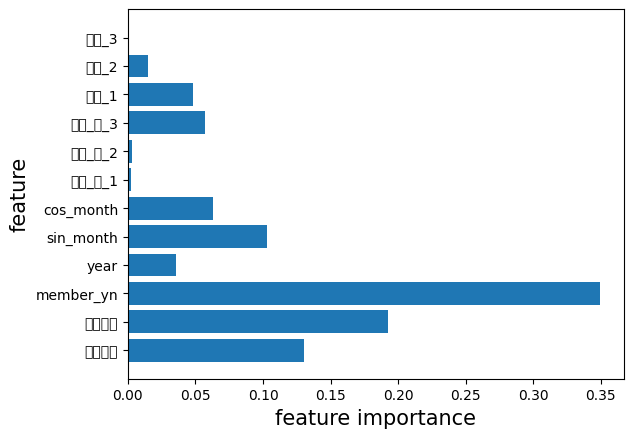

In [89]:
n_feature = X_train.shape[1]

index = np.arange(n_feature)

plt.barh(index, model.feature_importances_, align='center')

plt.yticks(index, X_train.columns)

plt.ylim(-1, n_feature)

plt.xlabel('feature importance', size=15)

plt.ylabel('feature', size=15)

plt.show()

In [90]:
import xgboost
from sklearn.metrics import mean_absolute_error as MAE

def modeling(X_train,y_train,X_valid,y_valid):
    def objective(trial):
        param = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.01, 1.0),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0)
        }
        model = xgboost.XGBRegressor(**param,random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_valid)
        return MAE(y_valid, y_pred)

    study = optuna.create_study(study_name='xgb', direction='minimize', sampler=optuna.samplers.TPESampler(seed=28))
    study.optimize(objective,n_trials=100,show_progress_bar=True)

    model = xgboost.XGBRegressor(**study.best_params,random_state=42)
    model.fit(X_train,y_train)

    return model

In [91]:
model = modeling(X_train,y_train,X_valid,y_valid)

[I 2023-09-27 06:10:53,542] A new study created in memory with name: xgb


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-09-27 06:10:53,680] Trial 0 finished with value: 28658.176090406538 and parameters: {'max_depth': 8, 'learning_rate': 0.5656272063043647, 'n_estimators': 168, 'min_child_weight': 4, 'gamma': 0.7834951242107413, 'subsample': 0.515883051836582, 'colsample_bytree': 0.19086642483166677, 'reg_alpha': 0.8549777464963643, 'reg_lambda': 0.9558181737084611}. Best is trial 0 with value: 28658.176090406538.
[I 2023-09-27 06:10:54,770] Trial 1 finished with value: 19390.931300059412 and parameters: {'max_depth': 10, 'learning_rate': 0.20077396408909462, 'n_estimators': 973, 'min_child_weight': 3, 'gamma': 0.03609031002477195, 'subsample': 0.9465997396659861, 'colsample_bytree': 0.9225076035007373, 'reg_alpha': 0.3010360101338607, 'reg_lambda': 0.17461096517703403}. Best is trial 1 with value: 19390.931300059412.
[I 2023-09-27 06:10:55,027] Trial 2 finished with value: 24639.51425965903 and parameters: {'max_depth': 4, 'learning_rate': 0.5155630374075781, 'n_estimators': 342, 'min_child_wei

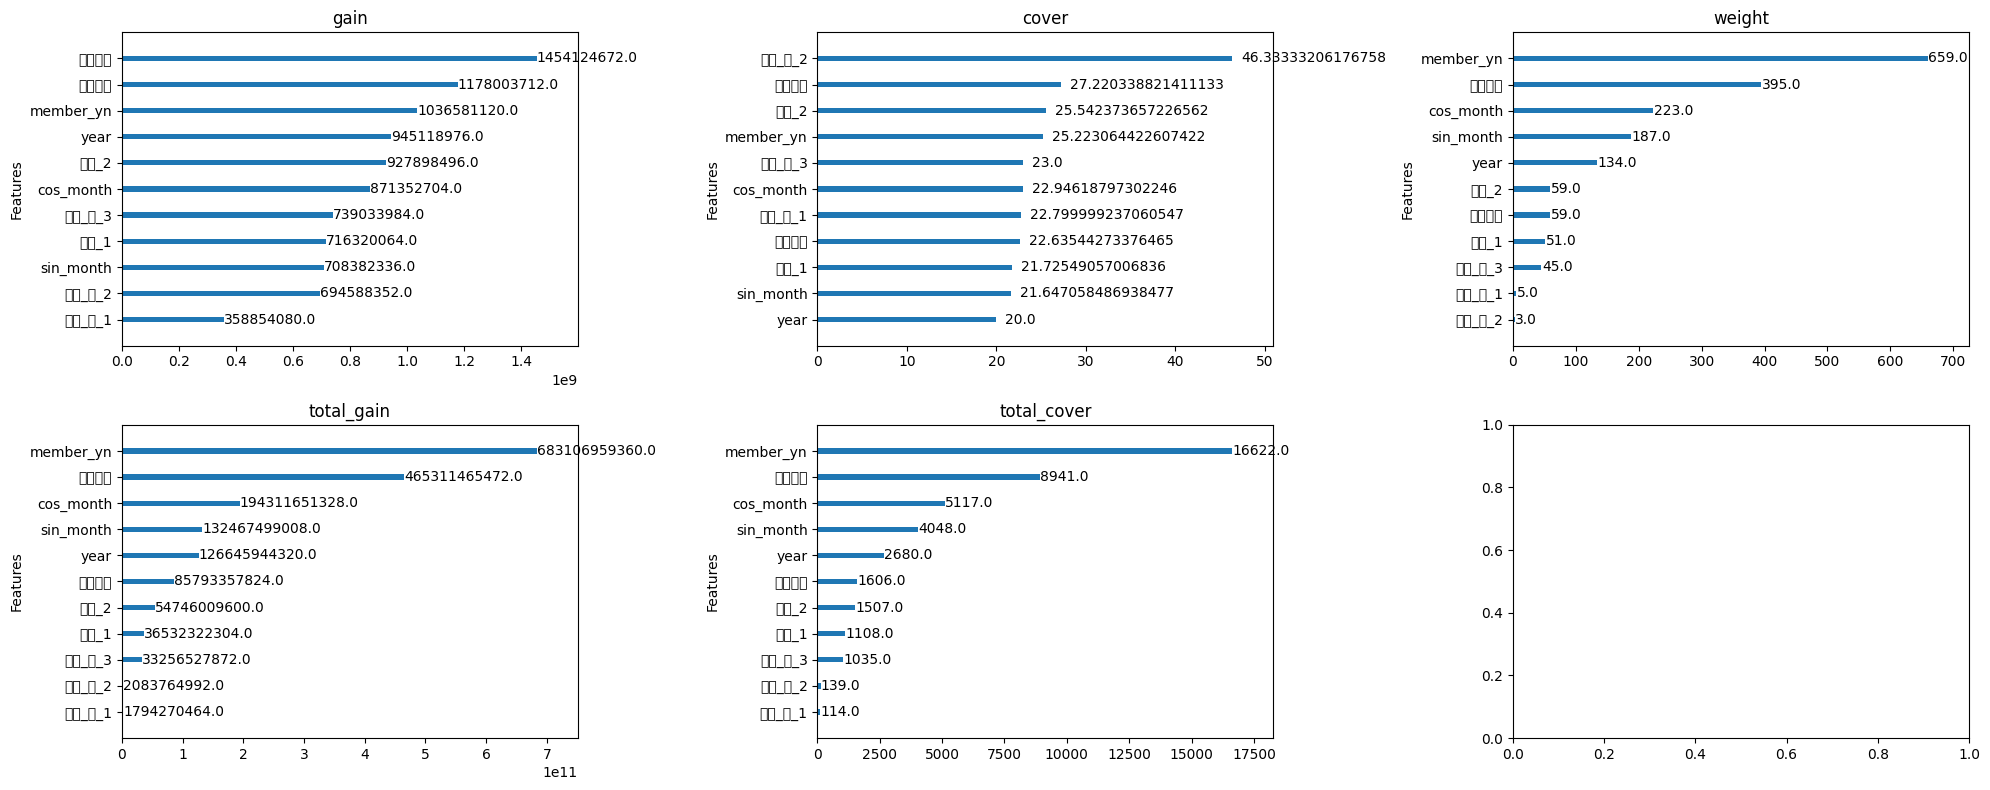

In [92]:
import matplotlib.pyplot as plt

fig,axes = plt.subplots(2,3,figsize=(20,8))

axes = [ax for row_axes in axes for ax in row_axes]

xgboost.plot_importance(model,importance_type='gain',title='gain',xlabel='',grid=False,ax=axes[0])
xgboost.plot_importance(model,importance_type='cover',title='cover',xlabel='',grid=False,ax=axes[1])
xgboost.plot_importance(model,importance_type='weight',title='weight',xlabel='',grid=False,ax=axes[2])
xgboost.plot_importance(model,importance_type='total_gain',title='total_gain',xlabel='',grid=False,ax=axes[3])
xgboost.plot_importance(model,importance_type='total_cover',title='total_cover',xlabel='',grid=False,ax=axes[4])
plt.tight_layout()
plt.show()

## 벡터 유사도를 통한 top 3 유사한 공연 산출 및 R,S,A,B,C 비율 구하기

In [93]:
!pip install konlpy

In [94]:
import pandas as pd
import konlpy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
#plt.rc('font', family='AppleGothic')
import seaborn as sns

In [95]:
df = new_df[[ '공연/전시명', 'play_date', '후원', '내한공연','뉴스개수', '장르_재', 'member_yn', '객단가', 'text']]#, 'R', 'S', 'A','B', 'C']]

In [96]:
df['play_date'] = pd.to_datetime(df['play_date'])

df['year'] = df['play_date'].apply(lambda x:x.year)
df['month'] = df['play_date'].apply(lambda x:x.month)

df['sin_month'] = np.sin(2*np.pi*df['month']/12)
df['cos_month'] = np.cos(2*np.pi*df['month']/12)

df.drop(['play_date','month'],axis=1,inplace=True)
df = pd.get_dummies(df, columns = ['장르_재','후원'],drop_first=True)

df.dropna(inplace=True)
df.shape

(401, 15)

In [97]:
df.head()

,공연/전시명,내한공연,뉴스개수,member_yn,객단가,text,year,sin_month,cos_month,장르_재_1,장르_재_2,장르_재_3,후원_1,후원_2,후원_3
0,김자경오페라단 50주년 기념 오페라갈라콘서트,0,1.0,0.033553,51415.384615,한국 오페라 발전에 크게 이바지한 김자경오페라단의 50주년을 맞이하여 예술의전당 콘...,2018,-5.000000e-01,0.866025,0,0,1,0,0,0
1,사랑과 희망의 하모니,0,41.0,0.024767,45803.278689,올해로 7회째를 맞이하는 '사랑과 희망의 하모니' 송년음악회가 예술의전당 콘서트홀에...,2018,-2.449294e-16,1.000000,0,0,1,0,0,0
2,서울모테트합창단 창단 30주년 기념 마스터피스 시리즈 II 헨델의 메시아,0,0.0,0.246639,22437.229437,"'맑고 깨끗한 울림, 정제된 화음,깊이 있는 음악으로 순수합창의 진수를 선보이는 최...",2018,-2.449294e-16,1.000000,0,0,1,1,0,0
6,제35회 한국오페라70주년기념 쏠리스트앙상블 송년음악회,0,0.0,0.019108,62317.073171,1984년 KBS합창단 출신 선후배들이 모여 첫 연주무대를 선보인 이래 스승과 제자...,2018,-2.449294e-16,1.000000,0,0,1,0,1,0
7,빈 필하모닉 멤버 앙상블 2019 신년음악회,1,0.0,0.615723,79542.944785,세계 최정상급으로 평가받고 있는 빈 필하모닉 오케스트라는 1842년 첫 공연을 시작...,2019,5.000000e-01,0.866025,0,0,1,0,1,0


In [98]:
df_cos_num = df.drop(['text','객단가','공연/전시명'],axis=1)
df_cos_num = pd.get_dummies(df_cos_num,columns=['year'])
df_cos_num.head()

,내한공연,뉴스개수,member_yn,sin_month,cos_month,장르_재_1,장르_재_2,장르_재_3,후원_1,후원_2,후원_3,year_2018,year_2019,year_2022,year_2023
0,0,1.0,0.033553,-5.000000e-01,0.866025,0,0,1,0,0,0,1,0,0,0
1,0,41.0,0.024767,-2.449294e-16,1.000000,0,0,1,0,0,0,1,0,0,0
2,0,0.0,0.246639,-2.449294e-16,1.000000,0,0,1,1,0,0,1,0,0,0
6,0,0.0,0.019108,-2.449294e-16,1.000000,0,0,1,0,1,0,1,0,0,0
7,1,0.0,0.615723,5.000000e-01,0.866025,0,0,1,0,1,0,0,1,0,0


In [99]:
cosine_sim = cosine_similarity(df_cos_num,df_cos_num)
cosine_sim.shape

(401, 401)

In [100]:
indices = pd.Series(df.index, index=df['공연/전시명']).drop_duplicates()
# 제목만 뽑는거

In [101]:
def find_index_by_event_name(event_name):
    """
    '공연/전시명' 열의 값이 event_name과 일치하는 행의 인덱스를 출력하는 함수
    """
    # event_name과 일치하는 행을 필터링하여 해당 행의 인덱스 출력
    matching_indexes = df.index[df['공연/전시명'] == event_name].tolist()
    return matching_indexes[0]

In [102]:
#예시
find_index_by_event_name('한경arte 더클래식 2023')

378

In [103]:
text_list = df['text'].tolist()
len(text_list)

401

In [104]:
string_list = [str(item) for item in text_list]

In [105]:
mydoclist_twitter = []

for contents in string_list:
    okt = konlpy.tag.Okt()
    twitter_nouns = ' '.join(okt.nouns(contents))
    mydoclist_twitter.append(twitter_nouns)

tfidf_vectorizer = TfidfVectorizer(min_df=1)
tfidf_matrix_twitter = tfidf_vectorizer.fit_transform(mydoclist_twitter)

similarity = cosine_similarity(tfidf_matrix_twitter, tfidf_matrix_twitter)
similarity.shape

(401, 401)

In [106]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = StandardScaler()

scaled_array1 = scaler.fit_transform(similarity)
scaled_array2 = scaler.fit_transform(cosine_sim)

cosine_sim_all = scaled_array1 + scaled_array2

In [107]:
df[['R','S','A','B','C']] = new_df.loc[df.index,['R','S','A','B','C']]

In [108]:
def get_recommendations(title, df, cosine_sim=cosine_sim_all):
    # 타이틀로부터 해당되는 인덱스를 받아옵니다.
    idx = find_index_by_event_name(title)
    # 모든 유사도를 구합니다.
    sim_scores = list(enumerate(cosine_sim_all[idx]))

    # 유사도에 따라 정렬합니다.
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # 가장 유사한 3개의 영화를 받아옵니다.
    sim_scores = sim_scores[1:4]

    # 가장 유사한 10개의 영화의 인덱스를 받아옵니다.
    movie_indices = [i[0] for i in sim_scores]

    new_df = df.copy()
    #new_df['공연/전시명'].drop_duplicates()

    new = new_df['객단가'].iloc[movie_indices]
    # real = new_df[new_df['공연/전시명']==title]['객단가']
    # mean = sum(new)/3
    # minus = real-mean

    R = df['R'].iloc[movie_indices]
    S = df['S'].iloc[movie_indices]
    A = df['A'].iloc[movie_indices]
    B = df['B'].iloc[movie_indices]
    C = df['C'].iloc[movie_indices]
    price_R = R/new
    price_S = S/new
    price_A = A/new
    price_B = B/new
    price_C = C/new

    # name = print("R:", R, "S: ", S, "A:",A,"B: ",B, "C :", C)


    # 가장 유사한 10개의 영화의 제목을 리턴합니다.
    # return print("유사 3개 공연의 평균값: ", mean, "실제 객단가 :", real, "차이 :", minus)
    print("R/객단가 :\n", price_R, "S/객단가:\n" , price_S,"A/객단가 :\n", price_A, "B/객단가:\n" , price_B, "C/객단가:\n" , price_C)

    return price_R, price_S, price_A, price_B, price_C

In [109]:
price_R, price_S, price_A, price_B, price_C = get_recommendations('런던 필하모닉',df)

R/객단가 :
 16         NaN
48    0.000444
12         NaN
dtype: float64 S/객단가:
 16         NaN
48    0.000222
12         NaN
dtype: float64 A/객단가 :
 16         NaN
48    0.000111
12         NaN
dtype: float64 B/객단가:
 16   NaN
48   NaN
12   NaN
dtype: float64 C/객단가:
 16   NaN
48   NaN
12   NaN
dtype: float64


# Test

### 위에서 학습시킨 객단가 예측 모델을 이용하여 객단가를 산출한 후 벡터 유사도가 가장 높은 것들 중 R,S,A,B,C 값이 있는 공연 가격 비율에 객단가를 곱한다

In [110]:
df = new_df[['공연/전시명','play_date','후원','내한공연','뉴스개수','장르_재','member_yn','객단가']]

In [111]:
df['play_date'] = pd.to_datetime(df['play_date'])

df['year'] = df['play_date'].apply(lambda x:x.year)
df['month'] = df['play_date'].apply(lambda x:x.month)

df['sin_month'] = np.sin(2*np.pi*df['month']/12)
df['cos_month'] = np.cos(2*np.pi*df['month']/12)

df.drop(['play_date','month'],axis=1,inplace=True)
df = pd.get_dummies(df, columns = ['장르_재','후원'],drop_first=True)


df.dropna(inplace=True)
df.head()

,공연/전시명,내한공연,뉴스개수,member_yn,객단가,year,sin_month,cos_month,장르_재_1,장르_재_2,장르_재_3,후원_1,후원_2,후원_3
0,김자경오페라단 50주년 기념 오페라갈라콘서트,0,1.0,0.033553,51415.384615,2018,-5.000000e-01,0.866025,0,0,1,0,0,0
1,사랑과 희망의 하모니,0,41.0,0.024767,45803.278689,2018,-2.449294e-16,1.000000,0,0,1,0,0,0
2,서울모테트합창단 창단 30주년 기념 마스터피스 시리즈 II 헨델의 메시아,0,0.0,0.246639,22437.229437,2018,-2.449294e-16,1.000000,0,0,1,1,0,0
6,제35회 한국오페라70주년기념 쏠리스트앙상블 송년음악회,0,0.0,0.019108,62317.073171,2018,-2.449294e-16,1.000000,0,0,1,0,1,0
7,빈 필하모닉 멤버 앙상블 2019 신년음악회,1,0.0,0.615723,79542.944785,2019,5.000000e-01,0.866025,0,0,1,0,1,0


In [112]:
## 테스트해볼 공연명

show_name = '런던 필하모닉'

In [113]:
test_input = df.loc[df['공연/전시명']==show_name,df.columns[1:]]
answer = test_input['객단가']
test_input.drop(['객단가'],axis=1,inplace=True)

In [114]:
test_input.shape

(1, 12)

In [115]:
out = model.predict(test_input)
print(f'{show_name}의 예상 객단가는 {out[0]}원 입니다.')

런던 필하모닉의 예상 객단가는 134240.9375원 입니다.


In [116]:
answer
## 실제 답과 비슷한 객단가를 산출

37    132852.838934
Name: 객단가, dtype: float64

In [117]:
df = new_df[[ '공연/전시명', 'play_date', '후원', '내한공연','뉴스개수', '장르_재', 'member_yn', '객단가', 'text']]#, 'R', 'S', 'A','B', 'C']]

df['play_date'] = pd.to_datetime(df['play_date'])

df['year'] = df['play_date'].apply(lambda x:x.year)
df['month'] = df['play_date'].apply(lambda x:x.month)

df['sin_month'] = np.sin(2*np.pi*df['month']/12)
df['cos_month'] = np.cos(2*np.pi*df['month']/12)

df.drop(['play_date','month'],axis=1,inplace=True)
df = pd.get_dummies(df, columns = ['장르_재','후원'],drop_first=True)

df.dropna(inplace=True)
df.shape

(401, 15)

In [118]:
df[['R','S','A','B','C']] = new_df.loc[df.index,['R','S','A','B','C']]

In [119]:
price_R, price_S, price_A, price_B, price_C = get_recommendations('런던 필하모닉',df)

R/객단가 :
 16         NaN
48    0.000444
12         NaN
dtype: float64 S/객단가:
 16         NaN
48    0.000222
12         NaN
dtype: float64 A/객단가 :
 16         NaN
48    0.000111
12         NaN
dtype: float64 B/객단가:
 16   NaN
48   NaN
12   NaN
dtype: float64 C/객단가:
 16   NaN
48   NaN
12   NaN
dtype: float64


In [120]:
final_dict = {}
for price,class_ in zip([price_R, price_S, price_A, price_B, price_C],['R','S','A','B','C']):
  val = price.dropna().values
  if len(val)==0:
    break
  final_dict[class_] = val[0]

In [121]:
print(f'"{show_name}" 공연의 최종 예측 가격')
for key,item in final_dict.items():
  print(f'{key}석 가격 : ',item*10000*out[0],'원')

"런던 필하모닉" 공연의 최종 예측 가격
R석 가격 :  596626.3888888889 원
S석 가격 :  298313.19444444444 원
A석 가격 :  149156.59722222222 원


In [122]:
## 런던 필하모닉 공연은 오케스트라 공연이므로 common_

In [123]:
final_common

,visual,acoustic
C1,0.989943,0.428571
C2,0.929650,0.571429
C3,0.831346,0.714286
C4,0.751943,1.000000
H4,0.744169,0.500000
...,...,...
M2,0.333098,0.500000
X11,0.331803,0.500000
X14,0.331803,0.500000
A12,0.310598,0.642857


In [124]:
final_score = pd.DataFrame(final_common['acoustic']*2 + final_common['visual']*1,index = final_common.index,columns=['score'])
final_score.sort_values(by='score',inplace=True,ascending=False)

In [125]:
final_score

,score
C4,2.751943
C5,2.703583
C6,2.651761
B4,2.344660
D4,2.344660
...,...
H7,0.712021
X9,0.424265
X4,0.413789
X5,0.384825


In [126]:
final_score['seat'] = np.zeros((len(final_score),1))

In [127]:
list(final_dict.keys())[::-1]

['A', 'S', 'R']

In [128]:
per = 1/len(final_dict)

for i,class_ in zip(range(len(final_dict)),list(final_dict.keys())[::-1]):
  val = final_score['score'].quantile(per*i)
  final_score.loc[final_score['score']>=val,'seat']=class_

In [129]:
# 최종 좌석 등급 배정
final_score

,score,seat
C4,2.751943,R
C5,2.703583,R
C6,2.651761,R
B4,2.344660,R
D4,2.344660,R
...,...,...
H7,0.712021,A
X9,0.424265,A
X4,0.413789,A
X5,0.384825,A


In [130]:
#A11 좌석그룹은 시야점수가 낮지만
list(final_common['visual'].sort_values(ascending=False).index).index('A11')

76

In [131]:
#음향 점수가 높아서
list(final_common['acoustic'].sort_values(ascending=False).index).index('A11')

18

In [132]:
#최종 좌석 그룹의 등수에서 비교적 높은 등수를 기록함
list(final_score.index).index('A11')

36